In [1]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import lsqfit
import itertools
from tqdm import tqdm

In [2]:
from b2heavy.FnalHISQMetadata import params as mData

In [3]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter, phys_energy_priors
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object

In [4]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
DATA_2PT = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/lattice24'

BINSIZE  = {
    'MediumCoarse':13,
    'Coarse-2':    16,
    'Coarse-1':    11,
    'Coarse-Phys': 19,
    'Fine-1':      16,
    'Fine-Phys':   16,
    'SuperFine':   22
}

In [29]:
ENSEMBLE = 'Fine-Phys'
RATIO    = 'RA1'
MOMENTUM = '100'

# SMSLIST  = ['1S','RW']
SMSLIST  = ['1S']

In [30]:
# Correlation matrix specifics
DIAG   = False
BLOCK  = False
SCALE  = True
SHRINK = True
SVD    = 1E-12

In [31]:
# Specifics of the analysis
TMIN    = 2
NSTATES = 2
WPRIORS = True
JKFIT   = False

In the following we look for requisites for the ratio calculation

In [32]:
requisites = ratio_prerequisites(
    ens      = ENSEMBLE,
    ratio    = RATIO,
    mom      = MOMENTUM,
    readfrom = DATA_2PT,
    jk       = False
)

requisites

{'E0': 0.8359044218191733,
 'm0': 0.8268518179647764,
 'Z0': {'1S': 3.4036585542162476, 'd': 0.01228810113574781},
 'Zpar': {'1S': 3.503955955516256, 'd': 0.013262466924029019},
 'Zbot': {'1S': 3.3724825579944953, 'd': 0.012864999706751564},
 'Zp': {'1S': None, 'd': None},
 'wrecoil': 1.010948278346511,
 'jk': False}

Here we initialize the master object that contains a ratio at given momentum for a given ensemble

In [33]:
io = RatioIO(ENSEMBLE,RATIO,MOMENTUM,PathToDataDir=DATA_DIR)
robj = RatioFitter(
    io,
    jkBin     = BINSIZE[ENSEMBLE],
    smearing  = SMSLIST,
    readfrom  = DATA_2PT,
    **requisites
)

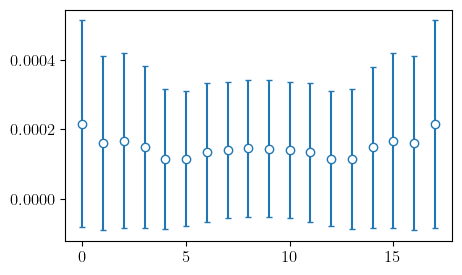

In [34]:
f, ax = plt.subplots(1,1,figsize=(5,3))
robj.plot(ax)

In [11]:
trange = (TMIN, robj.Ta-TMIN)

Here we elaborate the optimal $\epsilon$ cut for correlation matrix

In [13]:
cov_specs = dict(
    diag   = DIAG  ,
    block  = BLOCK ,
    scale  = SCALE ,
    shrink = SHRINK,
    # cutsvd = find_eps_cut(robj,trange)
    cutsvd = 1E-12
)

cov_specs

{'diag': False, 'block': False, 'scale': True, 'shrink': True, 'cutsvd': 1e-12}

Here we compute fit priors

In [14]:
dE_src = phys_energy_priors(ENSEMBLE,'D',MOMENTUM,NSTATES,readfrom=DATA_2PT,error=0.5)
dE_snk = phys_energy_priors(ENSEMBLE,'B',MOMENTUM,NSTATES,readfrom=DATA_2PT,error=0.5)

pr = robj.priors(NSTATES, dE_src=dE_src, dE_snk=dE_snk)
pr

{'ratio': [0.50(10)],
 'A_1S': [0 ± 1.0, 0 ± 1.0],
 'B_1S': [0 ± 1.0, 0 ± 1.0],
 'dE_src': [-1.11(50), -0.59(50)]}

Here we perform the fit

In [15]:
fit = robj.fit(
    Nstates = NSTATES,
    trange  = trange,
    priors  = pr,
    verbose = False,
    **cov_specs,
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [16]:
res = robj.fit_result(
    Nexc   = NSTATES,
    trange = trange,
    verbose = True,
    priors = pr 
)

# ---------- chi^2_exp analysis -------------
# chi2_exp = 14.000000000017295 +/- 5.291502622129574 
# p-value [eval] = 0.934
# p-value [MC]   = 0.9337
# ---------- 2+2 fit in (2, 15) for mes: RA1 of ens: Fine-1 for mom: 100 --------------
Least Square Fit:
  chi2/dof [dof] = 0.5 [14]    Q = 0.93    logGBF = 62.835

Parameters:
        ratio 0   0.506 (16)     [  0.50 (10) ]  
         A_1S 0   -0.08 (15)     [    0 ± 1.0 ]  
              1    0.14 (14)     [    0 ± 1.0 ]  
         B_1S 0   -0.13 (23)     [    0 ± 1.0 ]  
              1    0.29 (23)     [    0 ± 1.0 ]  
       dE_src 0   -1.12 (49)     [ -1.11 (50) ]  
              1   -0.51 (47)     [ -0.59 (50) ]  

Settings:
  svdcut/n = 0/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 9/0.2)
  fitter = scipy_least_squares    method = trf

# red chi2       = 6.88
# aug chi2       = 7.03
# chi2_exp       = 14.00
# chi2/chi_exp   = 0.50
# p-value (exp)  = 0.93
# p-value (std)  = 0.53


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


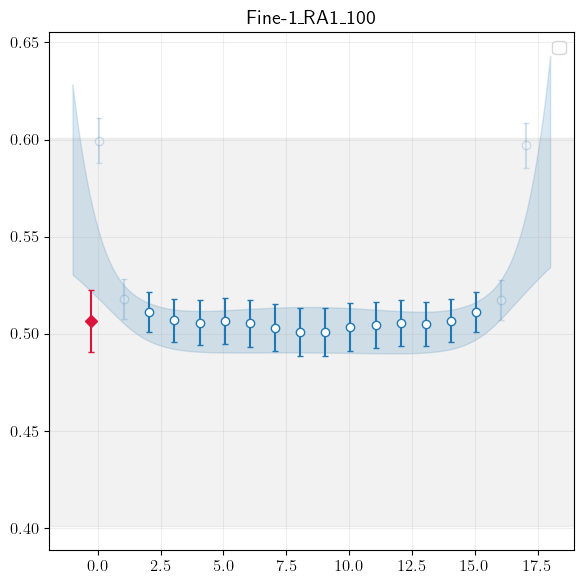

In [17]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

# f, ax = plt.subplots(1,1,figsize=(8,4))
f, ax = plt.subplots(1,1,figsize=(6,6))

robj.plot_fit(ax,NSTATES,trange)

f0 = pr['ratio'][0]
ax.axhspan(ymin=f0.mean-f0.sdev,ymax=f0.mean+f0.sdev,alpha=0.1,color='gray')

# ax.set_xlim(-0.5,18)
ax.grid(alpha=0.2)
ax.legend()
ax.set_title(f'{ENSEMBLE}_{RATIO}_{MOMENTUM}')
plt.tight_layout()
# plt.savefig('/Users/pietro/Desktop/bad_ratio.pdf')

# Model average for `Nstates` and trange

In [18]:
TIC = {}
pval = {}
for Nstates in [1,2,3]:
    dE_src = phys_energy_priors(ENSEMBLE,'Dst',MOMENTUM,Nstates,readfrom=DATA_2PT)
    dE_snk = phys_energy_priors(ENSEMBLE,'B'  ,MOMENTUM,Nstates,readfrom=DATA_2PT)
    x,ydata = robj.format(trange,flatten=True)
    pr = robj.priors(Nstates, dE_src=dE_src, dE_snk=dE_snk)

    for tmin in [1,2,3,4]:
        print(f'{Nstates=},{tmin=}')

        trange = (tmin, robj.Ta-tmin)

        fit = robj.fit(
            Nstates = Nstates,
            trange  = trange,
            priors  = pr,
            verbose = False,
            **cov_specs
        )

        res = robj.fit_result(
            Nexc   = Nstates,
            trange = trange,
            priors = pr,
            verbose = False
        )
        TIC[Nstates,trange] = float((res['chi2aug'] - 2*res['chiexp']))
        pval[Nstates,trange] = res['pstd']

Nstates=1,tmin=1
# ---------- chi^2_exp analysis -------------
# chi2_exp = 15.999999999999671 +/- 5.6568542494928495 
# p-value [eval] = 0.7873
# p-value [MC]   = 0.7847999999999999
Nstates=1,tmin=2
# ---------- chi^2_exp analysis -------------
# chi2_exp = 14.000000000000894 +/- 5.29150262212963 
# p-value [eval] = 0.7359
# p-value [MC]   = 0.7282
Nstates=1,tmin=3
# ---------- chi^2_exp analysis -------------
# chi2_exp = 11.999999999999611 +/- 4.8989794855664615 
# p-value [eval] = 0.7818
# p-value [MC]   = 0.7709
Nstates=1,tmin=4
# ---------- chi^2_exp analysis -------------
# chi2_exp = 10.000000000000878 +/- 4.47213595499974 
# p-value [eval] = 0.8869
# p-value [MC]   = 0.8942
Nstates=2,tmin=1
# ---------- chi^2_exp analysis -------------
# chi2_exp = 16.000000000003652 +/- 5.656854249492798 
# p-value [eval] = 0.8773
# p-value [MC]   = 0.8813
Nstates=2,tmin=2
# ---------- chi^2_exp analysis -------------
# chi2_exp = 13.999999999997238 +/- 5.291502622129536 
# p-value [eval] = 0

In [19]:
TIC

{(1, (1, 16)): -20.648140889935064,
 (1, (2, 15)): -17.551334452030016,
 (1, (3, 14)): -15.908932347404539,
 (1, (4, 13)): -14.97332807012101,
 (2, (1, 16)): -22.315548136493884,
 (2, (2, 15)): -20.543668682255756,
 (2, (3, 14)): -16.88207365584301,
 (2, (4, 13)): -15.626294054347902,
 (3, (1, 16)): -23.650200488809805,
 (3, (2, 15)): -20.683446210237502,
 (3, (3, 14)): -17.231466185523796,
 (3, (4, 13)): -15.816157925196332}

In [20]:
norm = np.exp(-np.array(list(TIC.values()))/2).sum()

vals = np.array([f.p['ratio'][0] for k,f in robj.fits.items()])
weig = np.array([np.exp(-TIC[k]/2)/norm for k in robj.fits]   )

stat = sum(vals * weig)
syst = np.sqrt(gv.mean(sum(weig*vals*vals) - (sum(weig*vals))**2))


print(stat,syst)

0.512(46) 0.010173535409181473


Print the results

KeyError: (1, (1, 15))

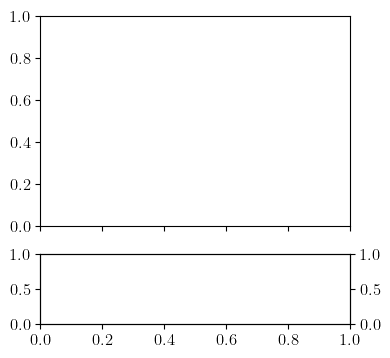

In [21]:
f, ax = plt.subplots(2,1,figsize=(4,4),gridspec_kw={'height_ratios': [3, 1]},sharex=True)

ts      = np.array([1,2,3,4])
tranges = [((t,robj.Ta-t-1)) for t in ts]

ax2 = ax[1].twinx()

for i,n in enumerate([1,2,3]):
    f0 = [robj.fits[n,tr].p['ratio'][0] for tr in tranges]
    off = -0.05*i + 0.05
    ax[0].errorbar(ts+off,gv.mean(f0),gv.sdev(f0),fmt='o', color=f'C{i}', capsize=2.5, label=f'({n+1}+{n+1})')

    tic = [np.exp(-TIC[n,tr]/2)/norm for tr in tranges]
    ax[1].plot(ts,tic,alpha=0.1,color=f'C{i}')
    # ax[1].scatter(ts,tic,marker='o',color=f'C{i}')

    pv = [pval[n,tr] for tr in tranges]
    ax2.scatter(ts,pv,color=f'C{i}',marker='.')


ax[0].axhspan(ymin=stat.mean-stat.sdev,ymax=stat.mean+stat.sdev,color='gray',alpha=0.2,label='model average')
err = np.sqrt(stat.sdev**2+syst**2)
ax[0].axhline(stat.mean-err,color='gray',alpha=0.2,linestyle=':')
ax[0].axhline(stat.mean+err,color='gray',alpha=0.2,linestyle=':')

ax[0].grid(alpha=0.2)
ax[0].legend(loc='lower right')
ax[0].set_ylabel(r'$F_0$')

ax[1].grid(alpha=0.2)
# ax[1].set_ylim(-0.1,1.1)
ax[1].set_ylabel(r'TIC weight')
ax[1].set_xlabel(r'$\frac{t_{min}}{a}$')

ax2.set_ylabel(r'$p$-value')

ax[0].set_title(f'{ENSEMBLE}_{RATIO}')

plt.tight_layout()
plt.savefig(f'/Users/pietro/Desktop/model_average_{ENSEMBLE}_{RATIO}_{MOMENTUM}.pdf')